0.1999999999990898


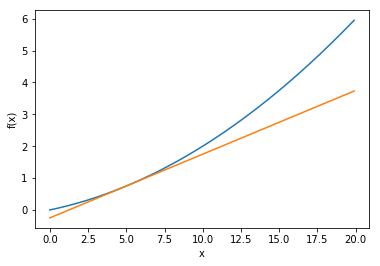

(2, 200)


ValueError: x and y must have same first dimension, but have shapes (2, 200) and (200,)

In [10]:

# 微分
def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)

def f1(x):
    return 0.01 * x ** 2 + 0.1 * x # y=0.01x2 + 0.1x

def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y


import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0.0, 20.0, 0.1)
y = f1(x)
tf = tangent_line(f1, 5)
y2 = tf(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.plot(x, y2)
plt.show()


# 偏微分
def f2(x):
    return x[0]**2 + x[1]**2

x2 = np.array([np.arange(0.0, 20.0, 0.1), np.arange(0.0, 20.0, 0.1)])
print(x2.shape)
y = f2(x2)
plt.plot(x2, y)
plt.show()